In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

### 问题： 在回归中，如果因变量$y$只有0和1值会发生什么

假如基于IRIS数据集，我们仅使用一个特征petal length识别是否是维吉尼亚鸢尾(Virginica)花

In [8]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data[:,2:3]
y = (iris.target == 2).astype(int)

2. 绘制散点图

In [9]:
iris_df = pd.DataFrame(np.hstack([X, y.reshape(-1,1)]), columns=["petal_length", "virginica"])

display(iris_df.iloc[np.r_[0:2, -2:0]])

,petal_length,virginica
0,1.4,0.0
1,1.4,0.0
148,5.4,1.0
149,5.1,1.0


In [10]:
np.r_[0:2, -2:0]# np.r_ 是NumPy中的一个特殊对象，用于快速构建数组索引。

array([ 0,  1, -2, -1])

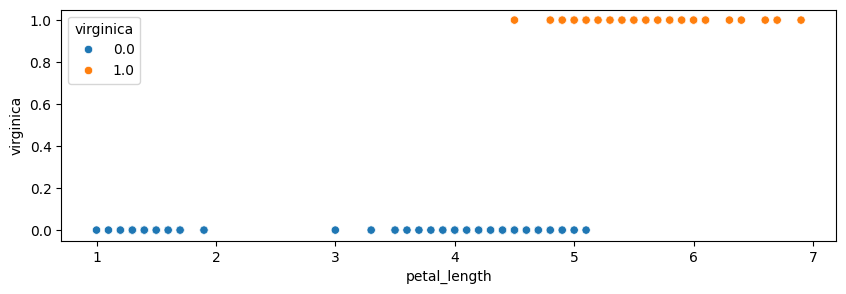

In [11]:
plt.figure(figsize=(10,3), dpi=100)
sns.scatterplot(x="petal_length", y="virginica", hue="virginica", data=iris_df);

In [12]:
import statsmodels.formula.api as smf
# Ordinary Least Squares
model = smf.ols(formula="virginica ~ petal_length ", data=iris_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              virginica   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     160.2
Date:                 周二, 11 11月 2025   Prob (F-statistic):           2.38e-25
Time:                        20:47:47   Log-Likelihood:                -45.010
No. Observations:                 150   AIC:                             94.02
Df Residuals:                     148   BIC:                             100.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3927      0.063     -6.201      0.000      -0.518      -0.268
petal_length     0.1932      0.015     12.659      0.000       0.163       0.223
==============================================================================
Omnibus:                       83.991   Durbin-Watson:                   0.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.390
Skew:                          -0.431   Prob(JB):                     0.000750
Kurtosis:                       1.752   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

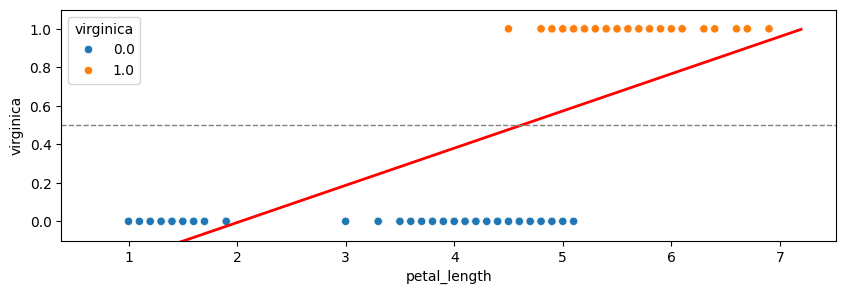

In [13]:
plt.figure(figsize=(10, 3), dpi=100)
sns.scatterplot(x="petal_length", y="virginica", hue="virginica", data=iris_df)

x_vals = np.array(plt.gca().get_xlim())
y_vals = model.predict(pd.DataFrame(x_vals.reshape(-1,1), columns=["petal_length"]))

plt.plot(x_vals, y_vals, ls="-", c="red", lw=2)
plt.axhline(0.5, c="grey", ls="--", lw=1)
plt.ylim(-0.1,1.1)
plt.show()

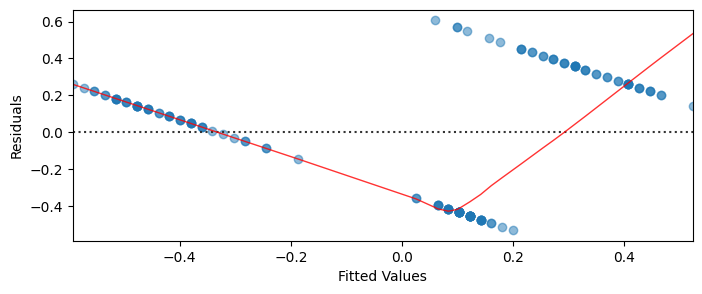

In [14]:
plt.figure(figsize=(8, 3), dpi=100)
sns.residplot(
    x=model.resid,
    y=model.fittedvalues,
    lowess=True,# lowess平滑
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plt.xlabel("Fitted Values"); plt.ylabel("Residuals");

<br/>

根据阈值$< 0.5$或者$> 0.05$判定是否为$0$或$1$:

In [15]:
y_pred = (model.predict(iris_df) >= 0.5).astype(int)

print("Errors: ", (y_pred != y).sum())

Errors:  12


In [16]:
accuracy_score(y, y_pred)

0.92

<br>

如果将上面的直线“掰”弯呢？

(-0.1, 1.1)

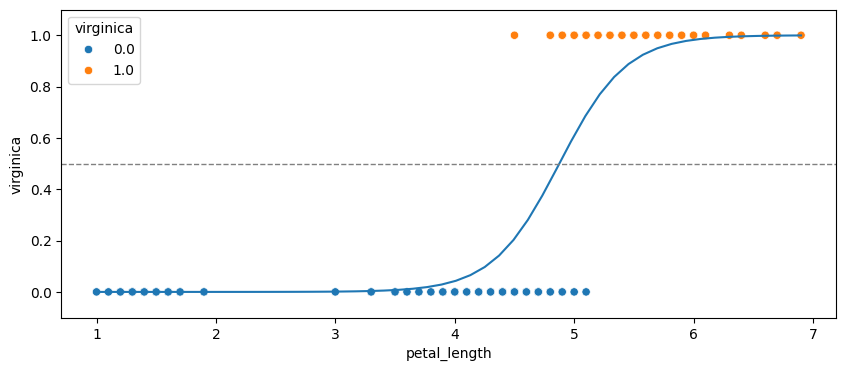

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X,y)

plt.figure(figsize=(10,4), dpi=100)
sns.scatterplot(x="petal_length", y="virginica", hue="virginica", data=iris_df)

X_seq = np.linspace(X.min(),X.max()).reshape(-1,1)
plt.plot(X_seq, model.predict_proba(X_seq)[:,1])
plt.axhline(0.5, c="grey", ls="--", lw=1)

plt.ylim(-0.1,1.1)


In [18]:
accuracy_score(y, model.predict(X))

0.9533333333333334

<br>

这里把直线掰弯，从数学上表达，将原先线性模型
$$
y = \beta_0 + \beta_1 x + \varepsilon
$$
变为
$$
f(y) = \beta_0 + \beta_1 x  + \varepsilon
$$

问题核心，如何寻找函数$f$，使得$f(y)$与$x$是线性关系，虽然$y$与$x$不是线性关系


# 逻辑回归

逻辑回归（Logistic Regression）是一种用于解决二分类（0 or 1）问题的机器学习方法，用于估计某种事物的可能性。比如某用户购买某商品的可能性，某病人患有某种疾病的可能性，以及某广告被用户点击的可能性等。 注意，这里用的是“可能性”，而非数学上的“概率”，logisitc回归的结果并非数学定义中的概率值，不可以直接当做概率值来用。该结果往往用于和其他特征值加权求和，而非直接相乘。


与线性回归不同，逻辑回归的因变量（被解释变量）是一个二元逻辑值，$0$和$1$。
 



如果随机变量$Y$是$0-1$事件，不妨定义$p=\mathrm{Pr}(Y=1)$，随机事件$Y=1$发生的概率


$$
\begin{aligned}
\mathrm{logit}(p) = \log\frac{p}{1 - p} 
= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_K x_K + \varepsilon
\end{aligned}
$$

可以看做

$$
\begin{aligned}
\mathrm{odd}(p)=\frac{p}{1 - p} 
&= e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_K x_K} \\
&= e^{\beta_0} \cdot e^{\beta_1 x_1} \cdot e^{\beta_2 x_2} \cdots e^{\beta_K x_K}
\end{aligned}
$$


其中的$\frac{p}{1-p}$，称为odds，一个事件的“**发生比**”或“发生几率”，该事件发生和不发生的比率。

发生比函数$\mathrm{odd}(p)$是$p$得单调增函数，当$p=0.5$时，$\mathrm{odd}(p)=1$。


假如自变量$x_1$的系数$\beta_1=1$时，如果$x_1$增加$1$个单位，那么事件发生比会是原来的$e^{\beta_1 x_1}=e \approx 2.71$倍，也就是“发生比”提高$2.71 - 1 = 171\%$。

<br>
绘制发生比(odd)函数

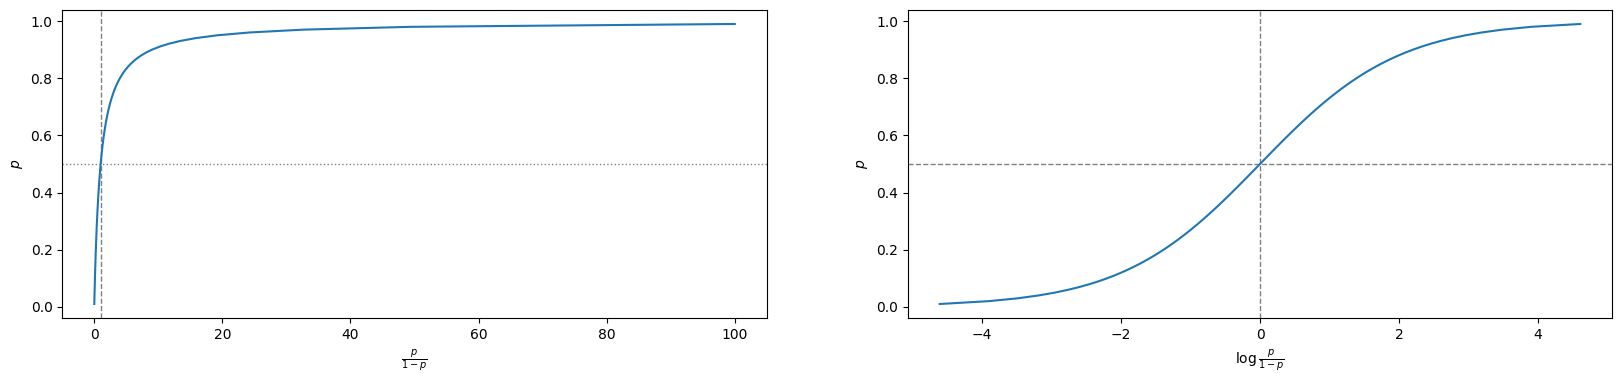

In [19]:
p = np.linspace(0, 1, num=101,endpoint=False)[1:] # 不包含0和1两端

# plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(1,2, figsize=(20,4))

axs[0].axhline(0.5, c="grey", ls=":", lw=1)
axs[0].axvline(1, c="grey", ls="--", lw=1)
axs[0].set_xlabel("$\\frac{p}{1-p}$")
axs[0].set_ylabel("$p$")
axs[0].plot(p/(1-p), p);

axs[1].set_xlabel(r"$\log\frac{p}{1-p}$")
axs[1].set_ylabel("$p$")
axs[1].axhline(0.5, c="grey", ls="--", lw=1)
axs[1].axvline(0, c="grey", ls="--", lw=1)
axs[1].plot(np.log(p/(1-p)), p);


求解上式得到可能性$p$函数

$$
\begin{aligned}
p &=
{\frac {e^{\beta _{0}+\beta _{1}x_{1} + \beta_2 x_2 + \dots + \beta_K x_K }}
{e^{\beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2} + \dots + \beta_K x_K   }+ 1 }} \\
&={\frac {1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2  + \dots + \beta_K x_K )}}}
\end{aligned}
$$


该函数也是一种`Sigmoid`函数，因其形状形似字母$S$而命名：

$$
S(x)={\frac {1}{1+e^{-x}}}={\frac {e^{x}}{e^{x}+1}}
$$

### 实例: 泰坦尼克乘客生存分析
> The RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after it collided with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard the ship, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. The RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. The Titanic was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.

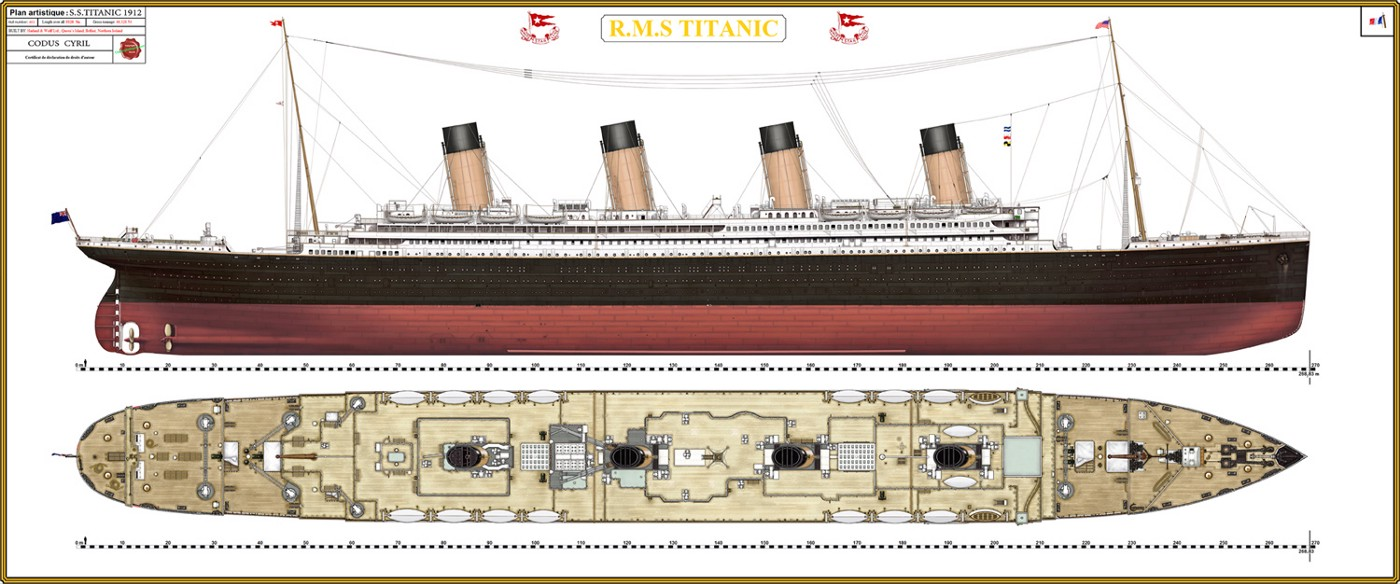

推测每位乘客幸存的可能性有多大

In [20]:
titanic = sns.load_dataset('titanic')

In [24]:
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
survive_df = pd.read_csv('datasets/titanic.csv')# 不知道数据集来源
print(survive_df.shape)
survive_df.head()

(1309, 14)


,Survived,PClass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Boat,Body,HomeDest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,0,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


数据特征(feature)有：
* Survival 是否生存 (0 = No; 1 = Yes)
* Pclass 客舱等级 (1 = Upper class; 2 = Middle class; 3 = Lower class)
* Name 乘客姓名
* Sex 乘客性别
* Age 乘客年龄，部分没有数据。Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
* SibSp 泰坦尼克号上的兄弟姐妹/配偶人数
* Parch 泰坦尼克上的家长/儿童人数
* Ticket 乘客票号
* Fare 乘客票价
* Cabin Cabin number of the passenger (Some entries contain NaN)
* Embarked 登船口岸 (C = Cherbourg; Q = Queenstown; S = Southampton)
* Body Body Identification Number (if did not survive and body was recovered)
* Home.Dest Home/Destination




In [3]:
survive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   PClass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   ParCh     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
 11  Boat      486 non-null    object 
 12  Body      121 non-null    float64
 13  HomeDest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [4]:
survive_df.Name

0                         Allen, Miss. Elisabeth Walton
1                        Allison, Master. Hudson Trevor
2                          Allison, Miss. Helen Loraine
3                  Allison, Mr. Hudson Joshua Creighton
4       Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
                             ...                       
1304                               Zabour, Miss. Hileni
1305                              Zabour, Miss. Thamine
1306                          Zakarian, Mr. Mapriededer
1307                                Zakarian, Mr. Ortin
1308                                 Zimmerman, Mr. Leo
Name: Name, Length: 1309, dtype: object

In [5]:
survive_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False).value_counts()

Name
Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Lady          1
Capt          1
Mme           1
Sir           1
Jonkheer      1
Dona          1
Don           1
Countess      1
Name: count, dtype: int64

In [6]:
survive_df = pd.read_csv('datasets/titanic.csv')


survive_df['Title'] = survive_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, 
                 "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, 
                 "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

survive_df['Title'] = survive_df['Title'].map(title_mapping)

In [7]:
survive_df

,Survived,PClass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Boat,Body,HomeDest,Title
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",3
2,0,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1
3,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0
4,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN,1
1305,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN,1
1306,0,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN,0
1307,0,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,0


In [8]:
survive_df['PClass'] = survive_df['PClass'].astype('str')

In [9]:
survive_df.drop(columns=['Ticket', 'Cabin', 'Boat', 'Body', 'HomeDest'], inplace=True);

Logistic回归不能处理存在NaN的数据，找出存在NaN的数据

In [10]:
survive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   PClass    1309 non-null   object 
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   ParCh     1309 non-null   int64  
 7   Fare      1308 non-null   float64
 8   Embarked  1307 non-null   object 
 9   Title     1309 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB


In [11]:
survive_df.isnull().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
1304    False
1305     True
1306    False
1307    False
1308    False
Length: 1309, dtype: bool

In [12]:
survive_df[survive_df.isnull().any(axis=1)]

,Survived,PClass,Name,Sex,Age,SibSp,ParCh,Fare,Embarked,Title
15,0,1,"Baumann, Mr. John D",male,NaN,0,0,25.9250,S,0
37,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,NaN,0,0,26.5500,S,0
40,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,39.6000,C,3
46,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,31.0000,S,0
59,1,1,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...",female,NaN,0,0,27.7208,C,2
...,...,...,...,...,...,...,...,...,...,...
1293,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,8.0500,S,0
1297,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,7.2500,S,0
1302,0,3,"Yousif, Mr. Wazli",male,NaN,0,0,7.2250,C,0
1303,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,14.4583,C,0


特征`Age`存在较多`NaN`数据

利用各Title分组(_Mr, Mrs, Miss, Others_)的年龄中位数作为`Age`的缺失值

In [13]:
survive_df.groupby("Title")["Age"].agg("median")

Title
0    29.0
1    22.0
2    35.5
3     9.0
Name: Age, dtype: float64

In [14]:
survive_df.groupby("Title")["Age"].transform("median")

0       22.0
1        9.0
2       22.0
3       29.0
4       35.5
        ... 
1304    22.0
1305    22.0
1306    29.0
1307    29.0
1308    29.0
Name: Age, Length: 1309, dtype: float64

In [15]:
survive_df["Age"].fillna(survive_df.groupby("Title")["Age"].transform("median"), inplace=True)

survive_df.drop(columns=['Title', 'Name'], inplace=True)

C:\Users\teach\AppData\Local\Temp\ipykernel_19224\872095306.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survive_df["Age"].fillna(survive_df.groupby("Title")["Age"].transform("median"), inplace=True)


特征`Fare`和`Embaked`还存在`NaN`数据

In [16]:
survive_df[survive_df.isnull().any(axis=1)]

,Survived,PClass,Sex,Age,SibSp,ParCh,Fare,Embarked
168,1,1,female,38.0,0,0,80.0,NaN
284,1,1,female,62.0,0,0,80.0,NaN
1225,0,3,male,60.5,0,0,NaN,S


In [17]:
survive_df["Fare"].fillna(survive_df.groupby(["PClass", 'Embarked'])["Fare"].transform("median"), inplace=True)

C:\Users\teach\AppData\Local\Temp\ipykernel_19224\2666888330.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survive_df["Fare"].fillna(survive_df.groupby(["PClass", 'Embarked'])["Fare"].transform("median"), inplace=True)


In [18]:
survive_df[survive_df.isnull().any(axis=1)]

,Survived,PClass,Sex,Age,SibSp,ParCh,Fare,Embarked
168,1,1,female,38.0,0,0,80.0,NaN
284,1,1,female,62.0,0,0,80.0,NaN


In [19]:
survive_df.isnull().sum()

Survived    0
PClass      0
Sex         0
Age         0
SibSp       0
ParCh       0
Fare        0
Embarked    2
dtype: int64

仅`Embarked`还存在2条缺失数据，这些缺失数据影响不大，因此忽删除这些缺失数据

In [20]:
survive_df.dropna(inplace=True)

In [21]:
survive_df[survive_df.isnull().any(axis=1)]

,Survived,PClass,Sex,Age,SibSp,ParCh,Fare,Embarked


In [22]:
survive_df

,Survived,PClass,Sex,Age,SibSp,ParCh,Fare,Embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,0,1,female,2.0000,1,2,151.5500,S
3,0,1,male,30.0000,1,2,151.5500,S
4,0,1,female,25.0000,1,2,151.5500,S
...,...,...,...,...,...,...,...,...
1304,0,3,female,14.5000,1,0,14.4542,C
1305,0,3,female,22.0000,1,0,14.4542,C
1306,0,3,male,26.5000,0,0,7.2250,C
1307,0,3,male,27.0000,0,0,7.2250,C


In [23]:
df = pd.get_dummies(survive_df)
X = df.drop("Survived", axis=1)
y = df["Survived"]

display(X.head())
display(y)

,Age,SibSp,ParCh,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,29.0000,0,0,211.3375,True,False,False,True,False,False,False,True
1,0.9167,1,2,151.5500,True,False,False,False,True,False,False,True
2,2.0000,1,2,151.5500,True,False,False,True,False,False,False,True
3,30.0000,1,2,151.5500,True,False,False,False,True,False,False,True
4,25.0000,1,2,151.5500,True,False,False,True,False,False,False,True


0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: Survived, Length: 1307, dtype: int64

基于Logistic回归模型建立模型

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=300)
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


In [25]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

0.7943107221006565
0.7760814249363868


In [26]:
model.coef_

array([[-0.03210433, -0.31034185, -0.06604185,  0.00204214,  0.87134489,
        -0.0032063 , -0.86635026,  1.30996847, -1.30818014,  0.33750405,
        -0.13219588, -0.20351984]])

In [27]:
model.coef_.shape

(1, 12)

In [28]:
print("accuracy of training: ", accuracy_score(y_train, model.predict(X_train)) )
print("accuracy of testing:  ", accuracy_score(y_test, model.predict(X_test)) )
print("intercept = ", model.intercept_[0])

pd.DataFrame(model.coef_, columns=X.columns, index=["coefficients"])

accuracy of training:  0.7943107221006565
accuracy of testing:   0.7760814249363868
intercept =  1.2122813290467627


,Age,SibSp,ParCh,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
coefficients,-0.032104,-0.310342,-0.066042,0.002042,0.871345,-0.003206,-0.86635,1.309968,-1.30818,0.337504,-0.132196,-0.20352


In [29]:
def plot_coefficients(coefficients, labels=None, ax=None):
    """
    以柱状图的方式显示系数
    """
    if ax is None: ax = plt.gca()
    
    ax.axhline(y=0, c="grey", lw=1)

    pos_val = coefficients[coefficients>=0]
    pos_idx = np.where(coefficients>=0)[0]
    neg_val = coefficients[coefficients<0]
    neg_idx = np.where(coefficients<0)[0]

    ax.bar(pos_idx, pos_val)
    ax.bar(neg_idx, neg_val)
    ax.set_ylabel("coefficients")

    ax.axes.set_xticks(range(len(coefficients)))
    if labels is not None:
        ax.axes.set_xticklabels(labels, horizontalalignment='right', rotation=45)
        
    ax.margins(y=0.15)
    for p in ax.patches:
        ax.annotate(f"{ p.get_height() :.2f}", 
                    xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                    xytext = (0, 8 if p.get_height() >= 0 else -8),
                    ha = 'center', va = 'center', textcoords = 'offset points')

In [30]:
np.exp(-1.31)

np.float64(0.2698200563846868)

In [31]:
np.exp(-0.03*60)

np.float64(0.16529888822158656)

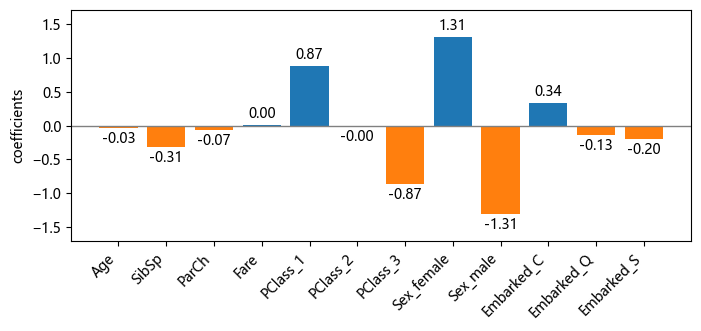

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))

plot_coefficients(model.coef_.ravel(), labels=X.columns, ax=None)

回归模型中，这组自变量`PClass_1`、`PClass_2`和`PClass_3`有着较强的共线性，在已知`PClass_1`和`PClass_2`条件，完全可以确定`PClass_3`的值，因此不影响结果，删除自变量`PClass_3`。同理，`Sex_female`和`Sex_male`以及`Embarked_C`、`Embarked_Q`和`Embarked_S`这两组也存在类似情况，删除`Sex_male`和`Embarked_S`自变量。


In [33]:
X_drop = X.drop(columns=['PClass_3', 'Sex_male', 'Embarked_S'])

X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size = 0.3, random_state = 101)

model2 = LogisticRegression(max_iter=200)
model2.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [34]:
print("accuracy of training: ", accuracy_score(y_train, model2.predict(X_train)) )
print("accuracy of testing:  ", accuracy_score(y_test,  model2.predict(X_test)) )

accuracy of training:  0.7964989059080962
accuracy of testing:   0.7786259541984732


In [35]:
print("intercept = ", model2.intercept_[0])
pd.DataFrame(model2.coef_, columns=X_drop.columns, index=["coefficients"])

intercept =  -1.1391894331596355


,Age,SibSp,ParCh,Fare,PClass_1,PClass_2,Sex_female,Embarked_C,Embarked_Q
coefficients,-0.031294,-0.309636,-0.06586,0.002428,1.64828,0.804423,2.568582,0.526109,0.044449


In [36]:
np.exp(2.57)

np.float64(13.065824440934556)

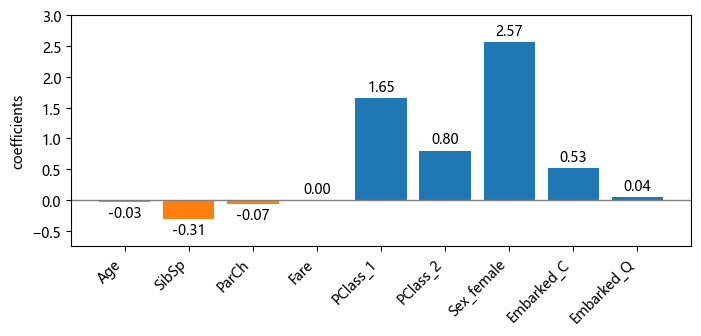

In [37]:
plt.figure(figsize=(8,3))

plot_coefficients(model2.coef_.ravel(), labels=X_drop.columns, ax=None)

In [38]:
model2

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


# 描述性统计

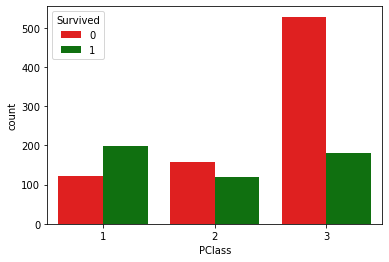

In [27]:
sns.countplot(x='PClass', hue='Survived', data=survive_df, palette=["red","green"]);

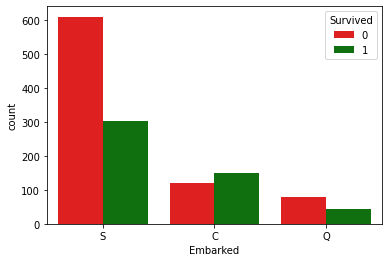

In [28]:
sns.countplot(x='Embarked', hue='Survived', data=survive_df, palette=["red","green"]);

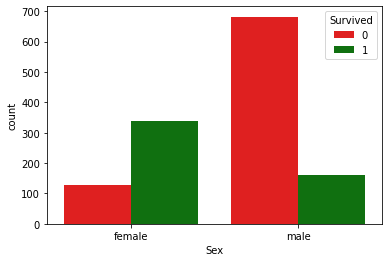

In [29]:
sns.countplot(x='Sex', hue='Survived', data=survive_df, palette=["red","green"]);

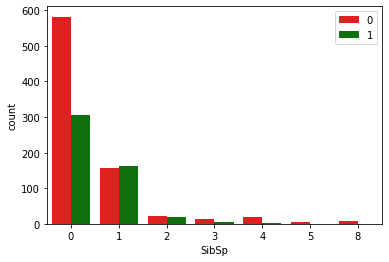

In [30]:
g = sns.countplot(x='SibSp', hue='Survived', data=survive_df, palette=["red","green"]);
g.legend(loc='upper right');

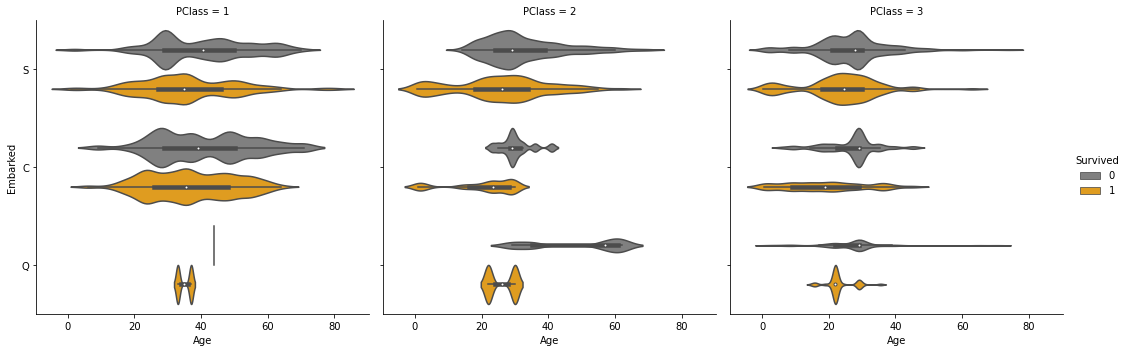

In [31]:
sns.catplot(x="Age", y="Embarked", hue="Survived", col="PClass",
            data=survive_df, kind="violin", bw=.2, palette=["grey", "orange"]);

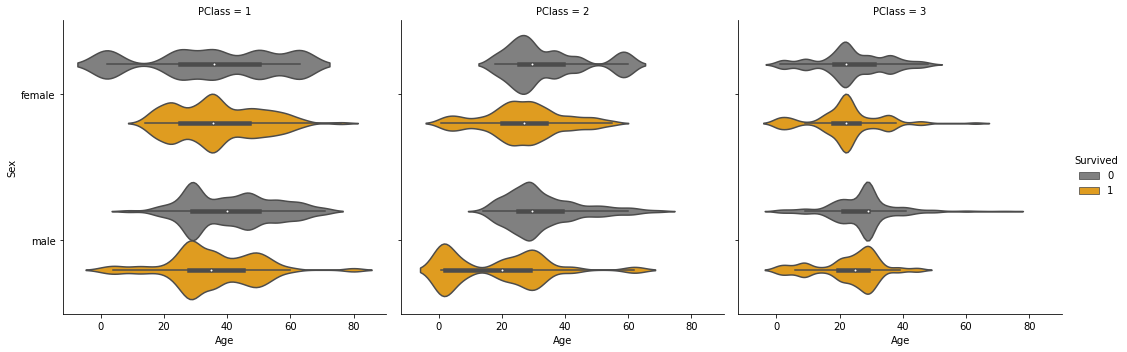

In [32]:
sns.catplot(x="Age", y="Sex", hue="Survived", col="PClass",
            data=survive_df, kind="violin", bw=0.2, palette=["grey", "orange"]);

#### 数据分析结论

$$
\begin{aligned}
\frac{p}{1 - p} 
= e^{-1.14}  e^{-0.03 \text{Age} } e^{-0.31 \text{SibSp}}  e^{-0.07 \text{ParCh}}  e^{0.00 \text{Fare}}  
e^{1.64 \text{PClass}_1} 
e^{0.80 \text{PClass}_2} 
e^{2.57 \text{Sex}_{\text{female}}} 
e^{0.53 \text{Embarked}_C} 
e^{0.04 Embarked_Q} e^{\varepsilon}
\end{aligned}
$$


当乘客为头等舱且是女性时，即$\text{PClass}_1=1$且$\text{Sex}_{\text{female}}=1$，

$$
e^{1.64 \text{PClass}_1} e^{2.57 \text{Sex}_{\text{female}}} = e^{1.64} e^{2.57} \approx 67.36
$$


对于头等舱女性乘客，即$\text{PClass}_1=1$且$\text{Sex}_{\text{female}}=1$，其生存可能性

$$
p > 0.3941
$$



In [49]:
0.99/0.01

99.0

,Age,SibSp,ParCh,Fare,PClass_1,PClass_2,Sex_female,Embarked_C,Embarked_Q
coefficients,76.0,3.0,4.0,25.7,1.0,0.0,1.0,0.0,0.0


In [59]:
cond = (X["PClass_1"]==1) & (X["Sex_female"]==1)

worst_cond = np.array([X[cond]["Age"].max(), 
                       X[cond]["SibSp"].max(), 
                       X[cond]["ParCh"].max(), 
                       X[cond]["Fare"].min(), 
                       1, 0, 1, 0, 0])

worst_p = 1/(1 + np.exp(-(model2.intercept_ + (model2.coef_ * worst_cond).sum())))

display(pd.DataFrame(np.array([worst_cond]), columns=X_drop.columns, index=["coefficients"]))

print(worst_p)

,Age,SibSp,ParCh,Fare,PClass_1,PClass_2,Sex_female,Embarked_C,Embarked_Q
coefficients,76.0,3.0,4.0,25.7,1.0,0.0,1.0,0.0,0.0


[0.39396936]


In [60]:
survive_df[(X["PClass_1"]==1) & (X["Sex_female"]==1)]["Survived"].value_counts()

Survived
1    137
0      5
Name: count, dtype: int64

In [61]:
137/(5+137)

0.9647887323943662

* 头等舱女性乘客的年龄分布

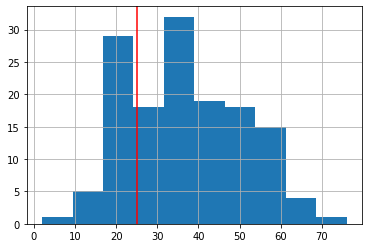

In [35]:
# 由于`&`的运算优先级高于`==`运算优先级，切记需要使用括弧改变优先级， 如`( ) & ( )`
X[(X["PClass_1"]==1) & (X["Sex_female"]==1)]["Age"].hist()
plt.axvline(x=25, c="red");

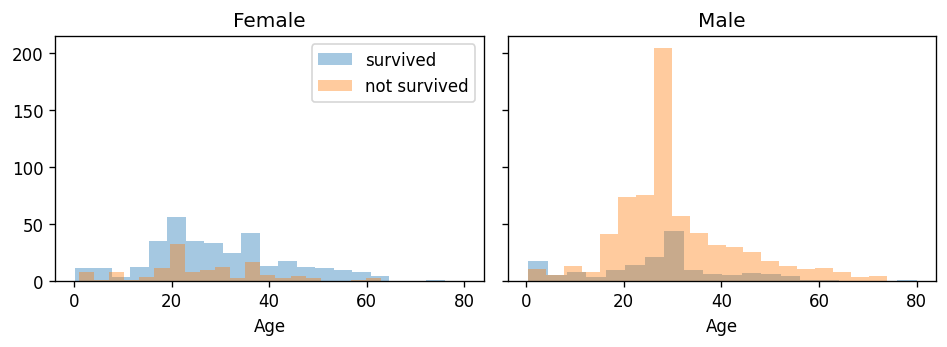

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True, dpi=120)

X_women = X[X['Sex_female']==1]
y_women = y[X['Sex_female']==1]
X_men = X[X['Sex_female']==0]
y_men = y[X['Sex_female']==0]

sns.distplot(X_women[y_women==1].Age, bins=20, label='survived', ax = axes[0], kde=False)
sns.distplot(X_women[y_women==0].Age, bins=20, label='not survived', ax = axes[0], kde=False)
axes[0].legend()
axes[0].set_title('Female')

sns.distplot(X_men[y_men==1].Age, bins=20, label = 'survived', ax = axes[1], kde = False)
sns.distplot(X_men[y_men==0].Age, bins=20, label = 'not survived', ax = axes[1], kde = False)
axes[1].set_title('Male')
fig.tight_layout()

一等仓女性乘客，当年龄$\le 40$，逻辑回归模型的生存概率 $p> 0.6671$

In [37]:
cond = (X["PClass_1"]==1) & (X["Sex_female"]==1)

age40_cond = np.array([40, 
                       X[cond]["SibSp"].max(), 
                       X[cond]["ParCh"].max(), 
                       X[cond]["Fare"].min(), 
                       1, 0, 1, 0, 0])

age40_p = 1/(1 + np.exp(-(model2.intercept_ + (model2.coef_ * age40_cond).sum())))

age40_p

array([0.66712048])

实际的生存比 $\frac{90}{90 + 3} \approx 0.9677$

> 注意：生存概率或生存可能性$p$，这个数值是由Logistic回归模型**拟合**得到，这与数据统计上的生存比（群体生存与群体总数之比）是不一样的。生存概率或生存可能性$p$，不仅蕴含了模型假设的信息也蕴含了在模型假设和限制下的样本的数据**回归(均值)**信息。

In [38]:
survive_df[(X["Age"] <= 40) & (X["PClass_1"]==1) & (X["Sex_female"]==1)]["Survived"].value_counts()

1    90
0     3
Name: Survived, dtype: int64

一等仓女性乘客，年龄$\le 25$，逻辑回归模型的生存概率$p > 0.7620$

In [39]:
cond = (X["PClass_1"]==1) & (X["Sex_female"]==1)

age20_cond = np.array([25, 
                       X[cond]["SibSp"].max(), 
                       X[cond]["ParCh"].max(), 
                       X[cond]["Fare"].min(), 
                       1, 0, 1, 0, 0])

age20_p = 1/(1 + np.exp(-(model2.intercept_ + (model2.coef_ * age20_cond).sum())))

age20_p

array([0.76204184])

实际的生存比 $\frac{35}{35 + 2} \approx 0.9459$

In [40]:
survive_df[(X["Age"] <= 25) & (X["PClass_1"]==1) & (X["Sex_female"]==1)]["Survived"].value_counts()

1    35
0     2
Name: Survived, dtype: int64

#### 计算生存概率（生存可能性）

In [32]:
model2.predict_proba(X_drop)

array([[0.06382779, 0.93617221],
       [0.40046029, 0.59953971],
       [0.05021967, 0.94978033],
       ...,
       [0.80580947, 0.19419053],
       [0.80824433, 0.19175567],
       [0.88362615, 0.11637385]])

In [62]:
model2.predict_proba(X_drop)[:, 1]

array([0.9360257 , 0.6003529 , 0.94986575, ..., 0.19390384, 0.19146981,
       0.11633464], shape=(1307,))

In [63]:
survival_prob = model2.predict_proba(X_drop)[:, 1]

survive_df["SurvivalProb"] = survival_prob

In [64]:
survive_df

,Survived,PClass,Sex,Age,SibSp,ParCh,Fare,Embarked,SurvivalProb
0,1,1,female,29.0000,0,0,211.3375,S,0.936026
1,1,1,male,0.9167,1,2,151.5500,S,0.600353
2,0,1,female,2.0000,1,2,151.5500,S,0.949866
3,0,1,male,30.0000,1,2,151.5500,S,0.376788
4,0,1,female,25.0000,1,2,151.5500,S,0.902194
...,...,...,...,...,...,...,...,...,...
1304,0,3,female,14.5000,1,0,14.4542,C,0.773326
1305,0,3,female,22.0000,1,0,14.4542,C,0.729577
1306,0,3,male,26.5000,0,0,7.2250,C,0.193904
1307,0,3,male,27.0000,0,0,7.2250,C,0.191470


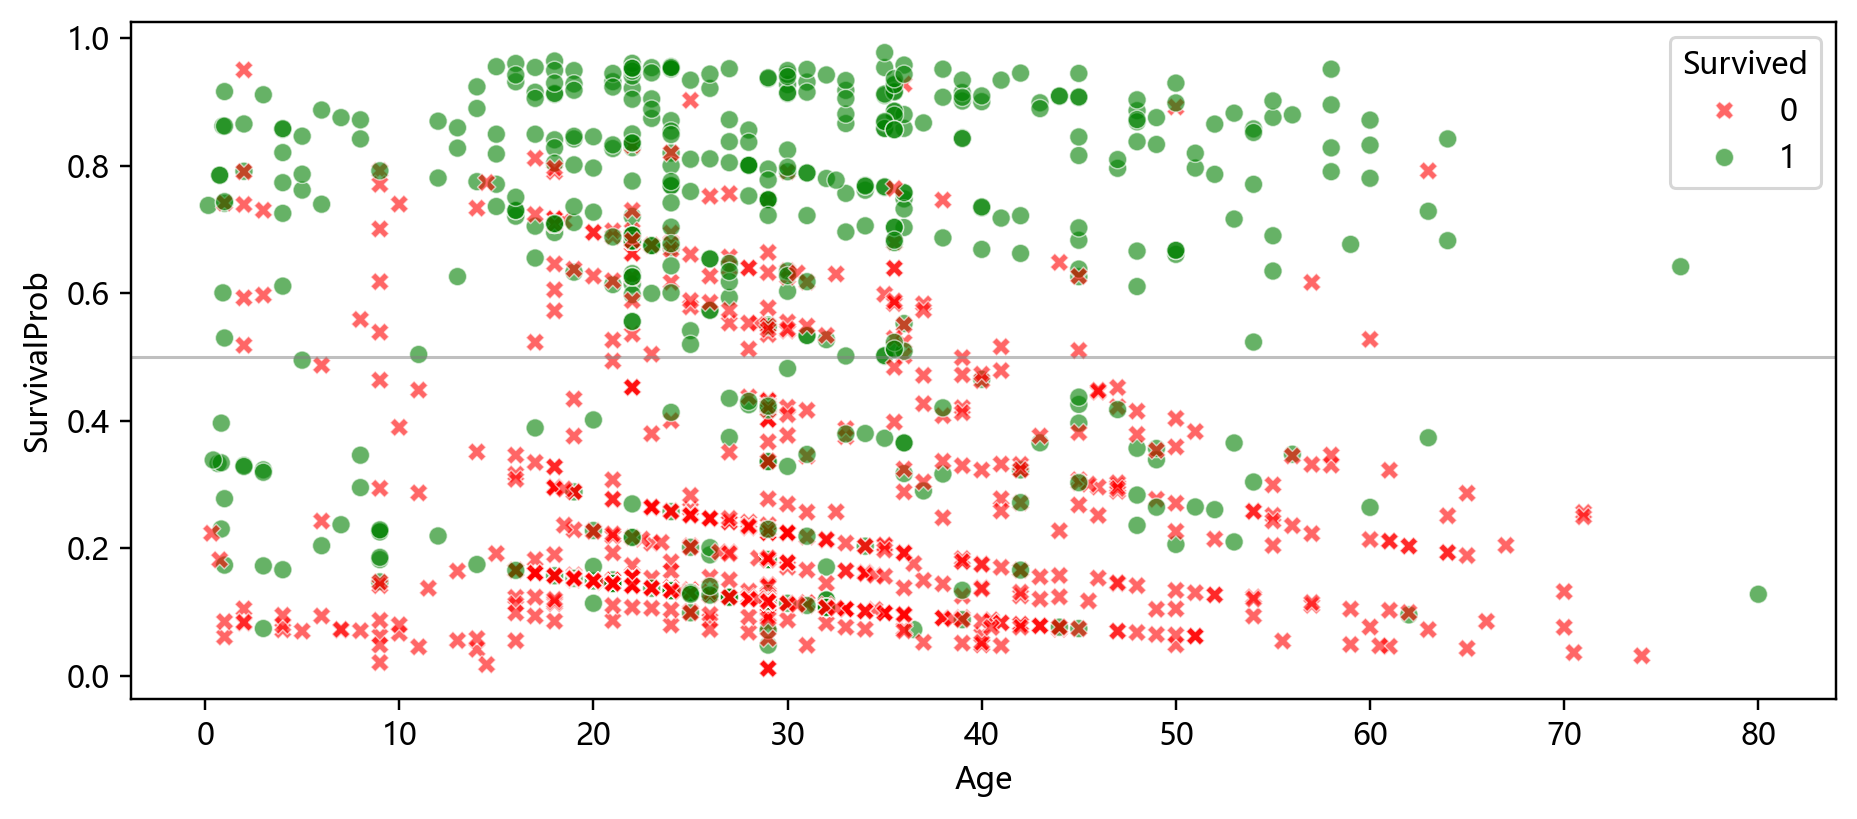

In [67]:
import seaborn as sns

plt.figure(figsize=(10,4), dpi=220)
sns.scatterplot(data=survive_df, x="Age", y="SurvivalProb", hue="Survived", style="Survived", 
                palette=["red", "green"], markers=["X", "o"], alpha=0.6);

plt.axhline(0.5, c="gray", alpha=0.5, lw=1)

> 注意: 上图中，低年龄段底部生存情况为何这样分布

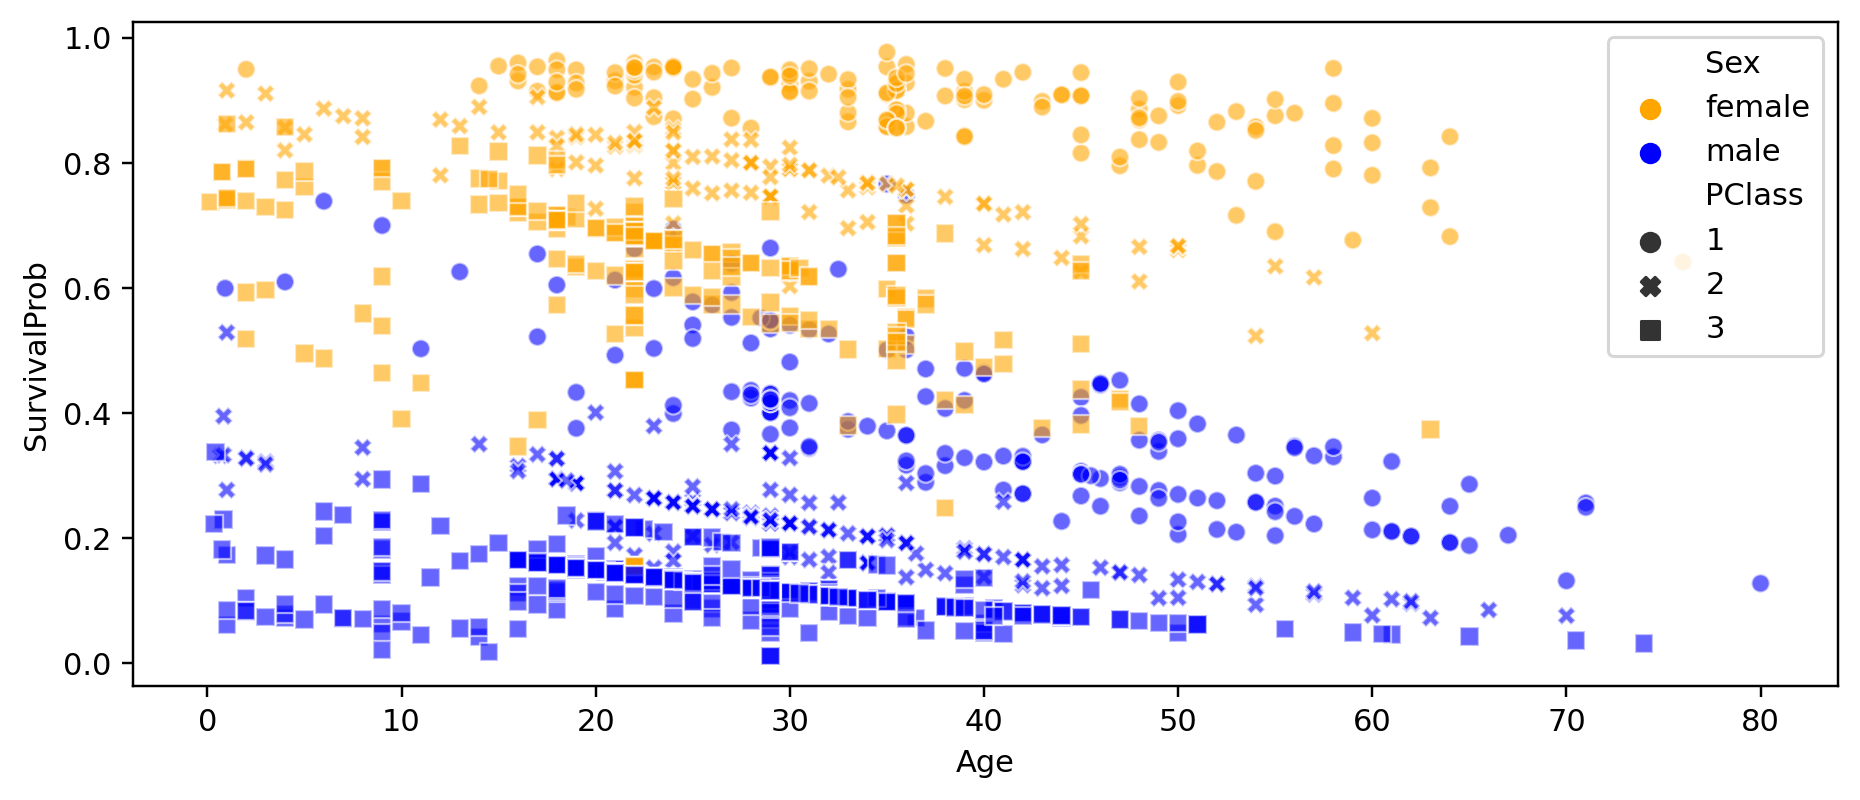

In [43]:
import seaborn as sns

plt.figure(figsize=(10,4), dpi=220)
sns.scatterplot(survive_df["Age"], survive_df["SurvivalProb"], 
                hue=survive_df["Sex"], palette=["orange", "blue"], alpha=0.6, style=survive_df["PClass"]);

### 为什么这些孩子生存可能性如此低？

In [44]:
survive_df[(survive_df["SurvivalProb"] <= 0.12) & (survive_df["Age"]<=16)]

,Survived,PClass,Sex,Age,SibSp,ParCh,Fare,Embarked,SurvivalProb
622,0,3,male,4.0,4,2,31.2750,S,0.071860
639,0,3,male,5.0,4,2,31.3875,S,0.069822
640,0,3,male,9.0,4,2,31.3875,S,0.062128
641,1,3,male,3.0,4,2,31.3875,S,0.073991
642,0,3,male,13.0,4,2,31.3875,S,0.055231
810,0,3,male,16.0,1,3,34.3750,S,0.112597
825,0,3,male,9.0,5,2,46.9000,S,0.048072
826,0,3,male,1.0,5,2,46.9000,S,0.060894
827,0,3,male,11.0,5,2,46.9000,S,0.045292
830,0,3,male,14.0,5,2,46.9000,S,0.041407


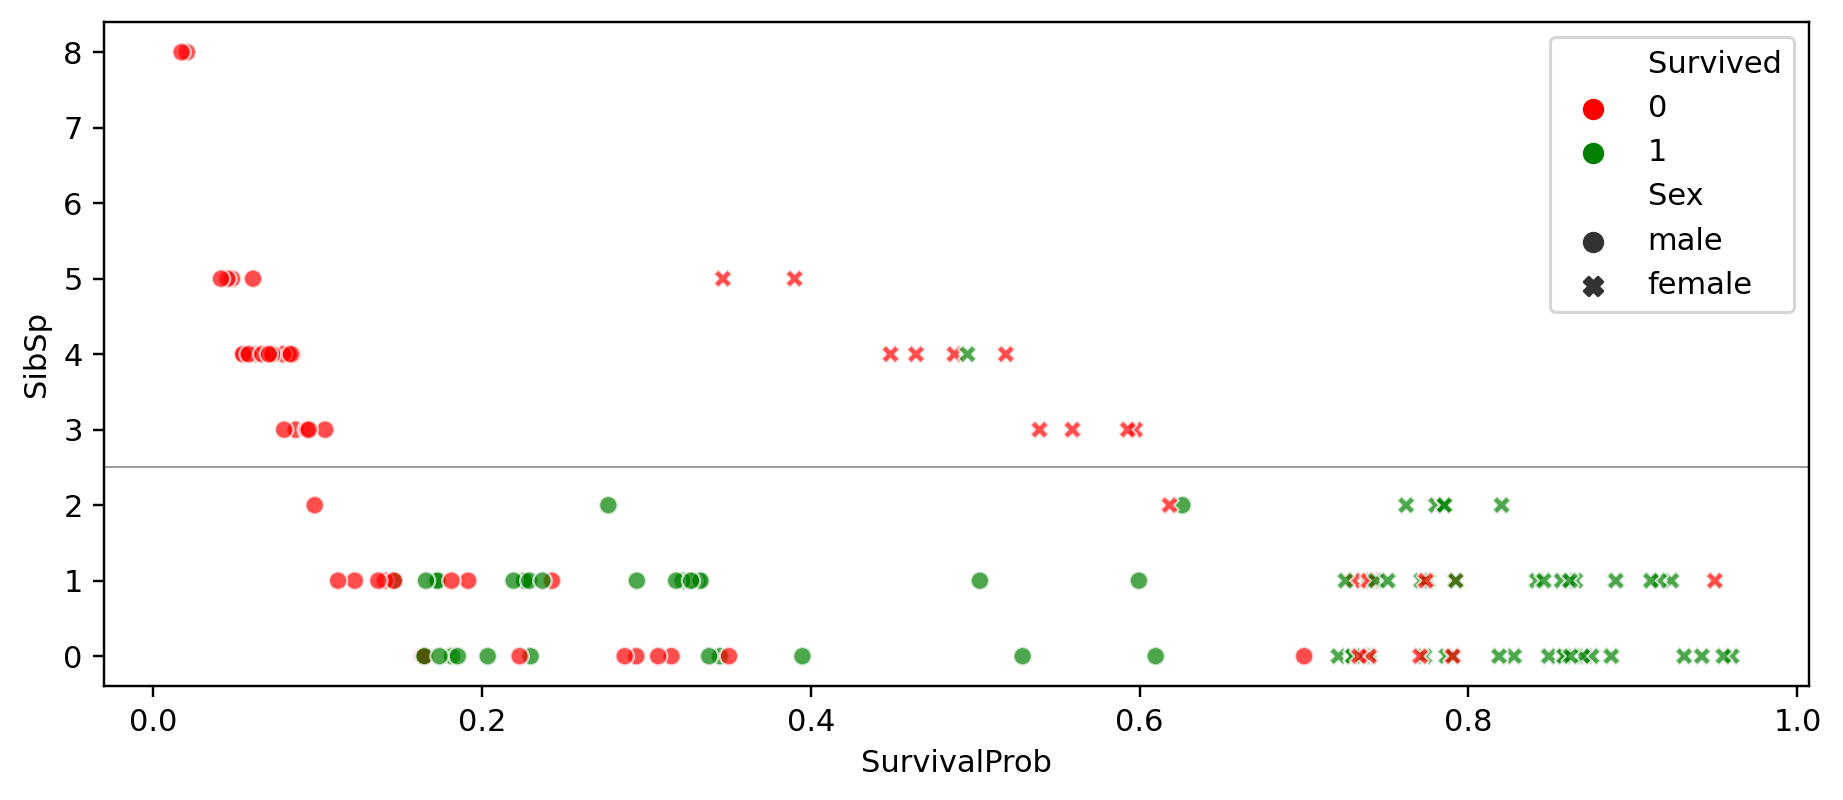

In [45]:
import seaborn as sns

children_df = survive_df[survive_df["Age"]<=16]

plt.figure(figsize=(10,4), dpi=220)
sns.scatterplot(children_df["SurvivalProb"], children_df["SibSp"],  
                hue=children_df["Survived"], alpha=0.7, palette=["red", "green"], style=children_df["Sex"]);
plt.axhline(y=2.5, c="grey", lw=0.5);

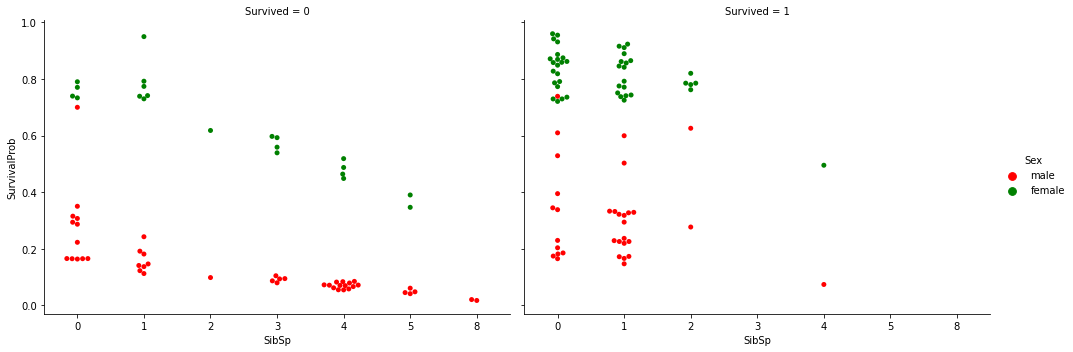

In [46]:
import seaborn as sns

children_df = survive_df[survive_df["Age"] <= 16]

sns.catplot(data=children_df, x="SibSp", y="SurvivalProb", col="Survived",
                hue="Sex", palette=["red", "green"], kind="swarm", aspect=1.4);

#### 计算生存概率


事件$Y=1$发生的概率$p$,
$$
\begin{aligned}
p ={\frac {1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2  + \dots + \beta_K x_K )}}}
\end{aligned}
$$


`LogisticRegression`使用`predict_proba`函数计算样本的发生概率$p$，该函数每个样本返回两个值为$0$和$1$的概率.



In [47]:
model2.predict_proba(X_drop)

array([[0.06391138, 0.93608862],
       [0.4004386 , 0.5995614 ],
       [0.05019102, 0.94980898],
       ...,
       [0.80582108, 0.19417892],
       [0.80825413, 0.19174587],
       [0.88365275, 0.11634725]])

In [48]:
# 利用公式手工计算
proba = 1 / (1 + np.exp( - ( model2.intercept_ + (X_drop.to_numpy() @  model2.coef_.T))))

# 判断手工公式计算和predict_proba函数计算的值是否一致
sum(proba.ravel() - model2.predict_proba(X_drop)[:, 1])

0.0

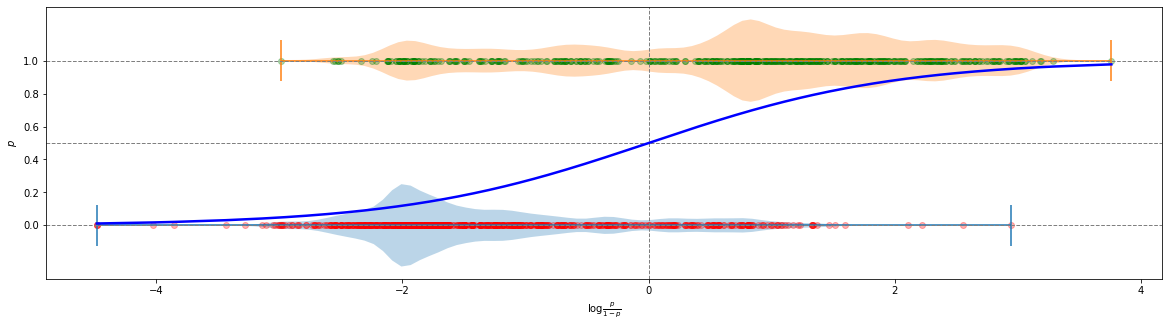

In [50]:
sorted_df = survive_df.sort_values(by=['SurvivalProb'])
p = sorted_df['SurvivalProb'] 
sorted_df['LogOdd'] = np.log(p/(1-p))

plt.figure(figsize=(20,5))
plt.axhline(0, c="grey", ls="--", lw=1)
plt.axhline(0.5, c="grey", ls="--", lw=1)
plt.axhline(1, c="grey", ls="--", lw=1)
plt.axvline(0, c="grey", ls="--", lw=1)

s_df = sorted_df[sorted_df["Survived"]==0]
plt.violinplot(s_df['LogOdd'], bw_method=0.1, vert=False, positions=[0])
plt.scatter(s_df['LogOdd'], s_df["Survived"], c="red", alpha=0.3)

s_df = sorted_df[sorted_df["Survived"]==1]
plt.violinplot(s_df['LogOdd'], bw_method=0.1, vert=False, positions=[1]);
plt.scatter(s_df['LogOdd'], s_df["Survived"], c="green", alpha=0.3)

plt.plot(sorted_df['LogOdd'], sorted_df['SurvivalProb'], lw=2.5, c="blue" );

yticks = np.linspace(0, 1, 6)
plt.yticks(yticks, [f'{y:0.1f}' for y in yticks])
plt.ylabel("$p$"); plt.xlabel(r"$\log\frac{p}{1-p}$");

### 练习： 进一步数据处理




In [59]:
survive_df = pd.read_csv('../datasets/titanic.csv')


survive_df['Title'] = survive_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, 
                 "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, 
                 "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

survive_df['Title'] = survive_df['Title'].map(title_mapping)
survive_df['PClass'] = survive_df['PClass'].astype('str')

survive_df["Age"].fillna(survive_df.groupby("Title")["Age"].transform("median"), inplace=True)

处理船舱`Cabin`， 增加 `Desk`

In [60]:
survive_df['Cabin'].isnull().sum()

1014

In [62]:
survive_df['Cabin'] = survive_df['Cabin'].fillna("U0")

import re
survive_df['Deck'] = survive_df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group()).astype("str")

In [63]:
survive_df['Deck'].value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Deck, dtype: int64

将年龄`Age`分段

In [64]:
survive_df['AgeBin'] = pd.cut(survive_df['Age'], bins = [0, 11, 18, 22, 27, 33, 40, 100])
survive_df['AgeBin'] = survive_df['AgeBin'].cat.codes.astype('str')
survive_df['AgeBin'].value_counts()

4    355
6    227
2    190
3    171
5    163
1    103
0    100
Name: AgeBin, dtype: int64

In [65]:
survive_df.drop(columns=['Ticket', 'Title', 'Cabin', 'Name', 'Boat', 'Body', 'HomeDest'], inplace=True);

survive_df.head()

,Survived,PClass,Sex,Age,SibSp,ParCh,Fare,Embarked,Deck,AgeBin
0,1,1,female,29.0000,0,0,211.3375,S,B,4
1,1,1,male,0.9167,1,2,151.5500,S,C,0
2,0,1,female,2.0000,1,2,151.5500,S,C,0
3,0,1,male,30.0000,1,2,151.5500,S,C,4
4,0,1,female,25.0000,1,2,151.5500,S,C,3


In [66]:
survive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   PClass    1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   ParCh     1309 non-null   int64  
 6   Fare      1308 non-null   float64
 7   Embarked  1307 non-null   object 
 8   Deck      1309 non-null   object 
 9   AgeBin    1309 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB
